In [ ]:
# importing required libraries
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os
from IPython.display import display, clear_output, HTML
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from pathlib import Path
import PIL
import numpy as np
from skimage import io
from skimage.color import rgba2rgb
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [ ]:
# initializing the cuda device for GPU usage
device=torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=3)

In [ ]:
# setting seed in a code ensures that the random numbers generated by the code are reproducible
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed = 42

#### **Augment images to increase data size per class to up to 1200 images**

#### Create Dataset to train dataset and validation dataset

In [ ]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Set the folder path
folder_path = 'augmented_images'

class CustomImageFolder(ImageFolder):
    def _find_classes(self, dir):
        classes, class_to_idx = super()._find_classes(dir)

        # Check and remove problematic images
        for class_name in classes:
            class_path = Path(dir) / class_name
            for img_path in class_path.iterdir():
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Verify if the image is truncated

                    # Reopen the image to convert it to RGB
                    with Image.open(img_path) as img:
                        img = img.convert("RGB")
                except (PIL.UnidentifiedImageError, OSError):
                    print(f"Removing problematic image: {img_path}")
                    img_path.unlink()

        return classes, class_to_idx



# Load the dataset
dataset = CustomImageFolder(folder_path, transform=data_transforms)

In [ ]:
# Split the dataset into training and validation sets
set_seed(seed)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
len(val_loader)

53

In [ ]:
# code to generate make_confusion matrix
def make_confusion_matrix(y_true,y_preds,class_names):    
    cm=confusion_matrix(y_true,y_preds)
    plt.figure(figsize=(14,10))
    sns.heatmap(cm,annot=True,cmap='Blues',fmt='.0f')
    display(HTML("<h2 style='font-weight:bold; color:#3498DB; text-align:center;'>Confusion Matrix</h2><hr>"))
    plt.ylabel("True values",size=15)
    plt.xlabel('Predicted values',size=15)
    plt.xticks(ticks=np.arange(len(class_names))+0.5,labels=class_names,rotation=60)
    plt.yticks(ticks=np.arange(len(class_names))+0.5,labels=class_names,rotation=0)

#### Baseline Model - 2 layer CNN Model

In [ ]:
# CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(401408, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        #print("Feature shape:", x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
# Instantiate the model
num_classes = len(dataset.classes)
set_seed(seed)
model = SimpleCNN(num_classes)

# Check if GPU is available and set the device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move your model to GPU
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)


    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Using device: cuda:0
Epoch 1/10: Train Loss - 0.0524, Train Accuracy - 0.4537
Epoch 2/10: Train Loss - 0.0351, Train Accuracy - 0.5980
Epoch 3/10: Train Loss - 0.0283, Train Accuracy - 0.6798
Epoch 4/10: Train Loss - 0.0223, Train Accuracy - 0.7458
Epoch 5/10: Train Loss - 0.0166, Train Accuracy - 0.8123
Epoch 6/10: Train Loss - 0.0126, Train Accuracy - 0.8657
Epoch 7/10: Train Loss - 0.0100, Train Accuracy - 0.8974
Epoch 8/10: Train Loss - 0.0078, Train Accuracy - 0.9221
Epoch 9/10: Train Loss - 0.0060, Train Accuracy - 0.9384
Epoch 10/10: Train Loss - 0.0043, Train Accuracy - 0.9595


In [ ]:
# Set the model to evaluation mode
set_seed(seed)
model.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []
# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels])  

val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')


Validation accuracy: 61.92%


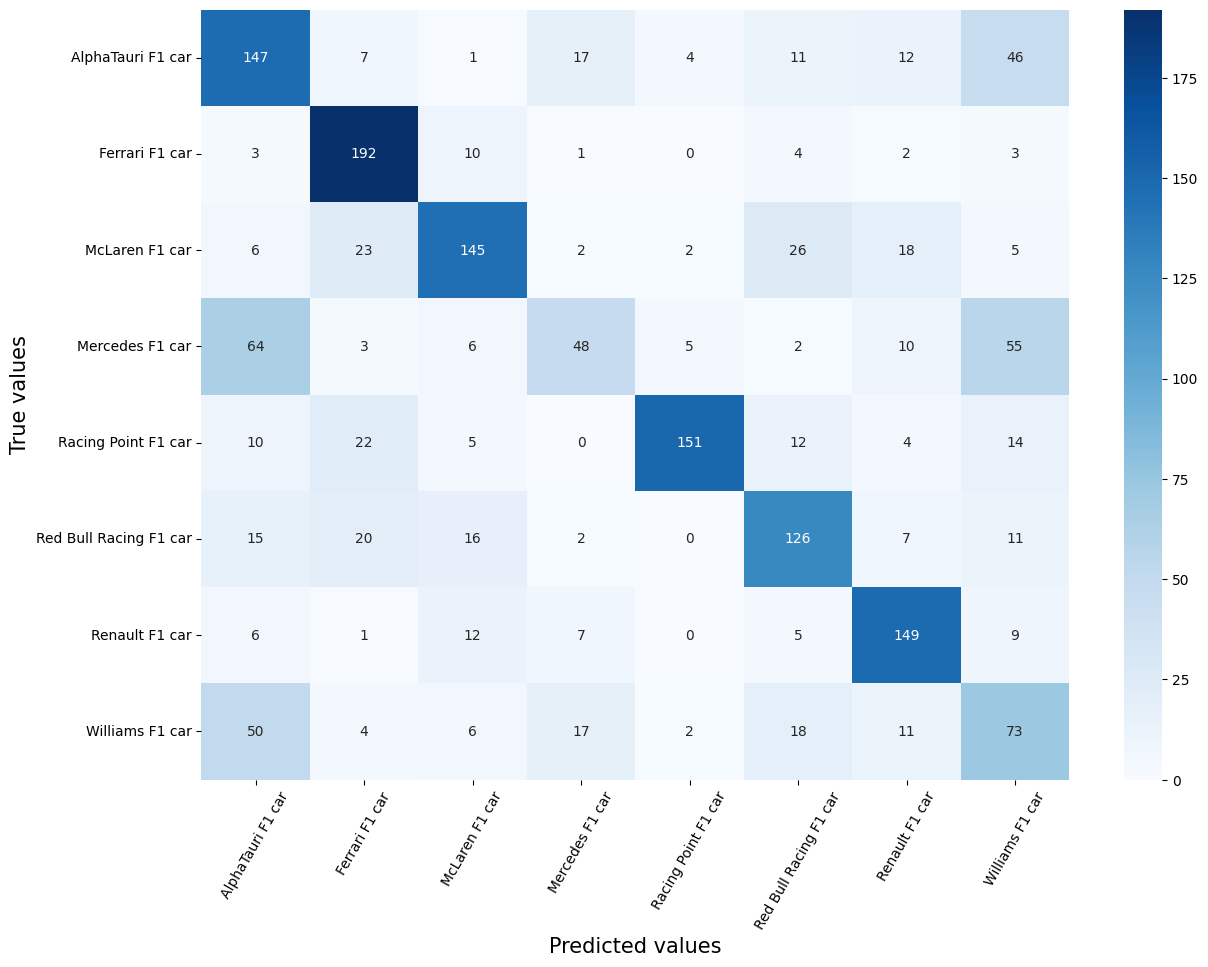

In [ ]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

In [ ]:
print(dataset.classes)

['AlphaTauri F1 car', 'Ferrari F1 car', 'McLaren F1 car', 'Mercedes F1 car', 'Racing Point F1 car', 'Red Bull Racing F1 car', 'Renault F1 car', 'Williams F1 car']


In [ ]:
# Saving the files for re-use

output_model_file = './SimpleCNN.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)

print('All files saved')

All files saved


#### Fine Tune RESNET-18 Model - freeze all feature extraction layers

In [ ]:
set_seed(seed)

# Load the pre-trained model
resnet18 = models.resnet18(pretrained=True)

# Freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match the number of classes in your dataset
num_classes = len(dataset.classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Move the model to the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)




In [ ]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    resnet18.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:
      
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0624, Train Accuracy - 0.2382
Epoch 2/10: Train Loss - 0.0538, Train Accuracy - 0.4454
Epoch 3/10: Train Loss - 0.0475, Train Accuracy - 0.5812
Epoch 4/10: Train Loss - 0.0429, Train Accuracy - 0.6402
Epoch 5/10: Train Loss - 0.0395, Train Accuracy - 0.6704
Epoch 6/10: Train Loss - 0.0368, Train Accuracy - 0.6914
Epoch 7/10: Train Loss - 0.0348, Train Accuracy - 0.7027
Epoch 8/10: Train Loss - 0.0330, Train Accuracy - 0.7190
Epoch 9/10: Train Loss - 0.0316, Train Accuracy - 0.7256
Epoch 10/10: Train Loss - 0.0303, Train Accuracy - 0.7321


In [ ]:
# Set the model to evaluation mode
set_seed(seed)
resnet18.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = resnet18(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels])  


val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 73.87%


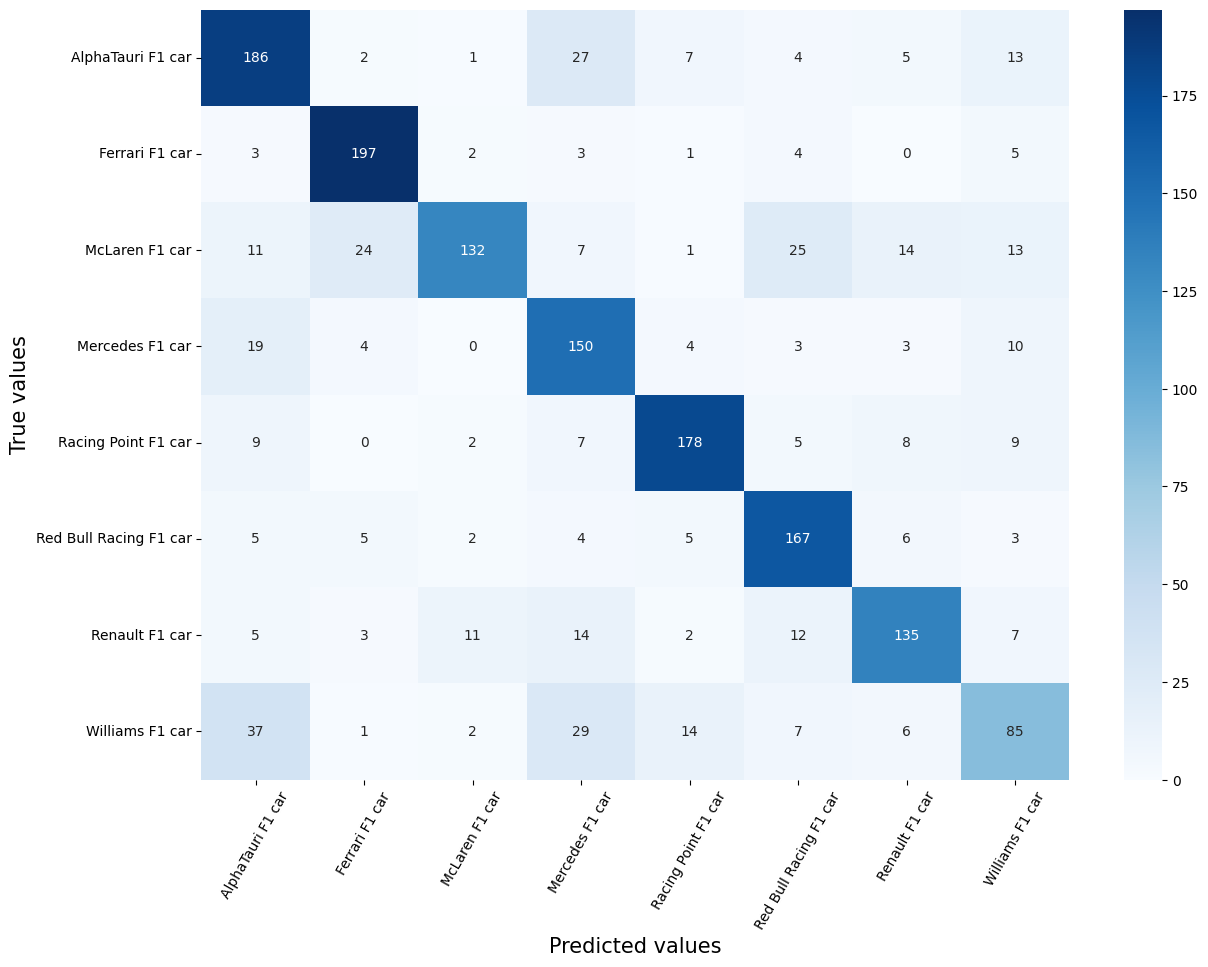

In [ ]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

In [ ]:
# Saving the files for re-use
output_model_file = './RESNET-18.bin'

model_to_save = resnet18
torch.save(model_to_save, output_model_file)

print('All files saved')

All files saved


#### Fine-Tune Full RESNET-18 Model

In [ ]:
# Load pre-trained ResNet and modify for your task
num_classes = len(dataset.classes)  # Number of Formula 1 car classes
set_seed(seed)
resnet18_all = models.resnet18(pretrained=True)
resnet18_all.fc = nn.Linear(resnet18_all.fc.in_features, num_classes)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_all = resnet18_all.to(device)



/home/varun/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/varun/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_all.parameters(), lr=0.0001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    resnet18_all.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_all(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0172, Train Accuracy - 0.8264
Epoch 2/10: Train Loss - 0.0041, Train Accuracy - 0.9671
Epoch 3/10: Train Loss - 0.0020, Train Accuracy - 0.9842
Epoch 4/10: Train Loss - 0.0017, Train Accuracy - 0.9922
Epoch 5/10: Train Loss - 0.0010, Train Accuracy - 0.9940
Epoch 6/10: Train Loss - 0.0004, Train Accuracy - 0.9971
Epoch 7/10: Train Loss - 0.0007, Train Accuracy - 0.9937
Epoch 8/10: Train Loss - 0.0011, Train Accuracy - 0.9902
Epoch 9/10: Train Loss - 0.0006, Train Accuracy - 0.9955
Epoch 10/10: Train Loss - 0.0007, Train Accuracy - 0.9938


In [ ]:
# Set the model to evaluation mode
set_seed(seed)
resnet18_all.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = resnet18_all(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels])  

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 95.50%


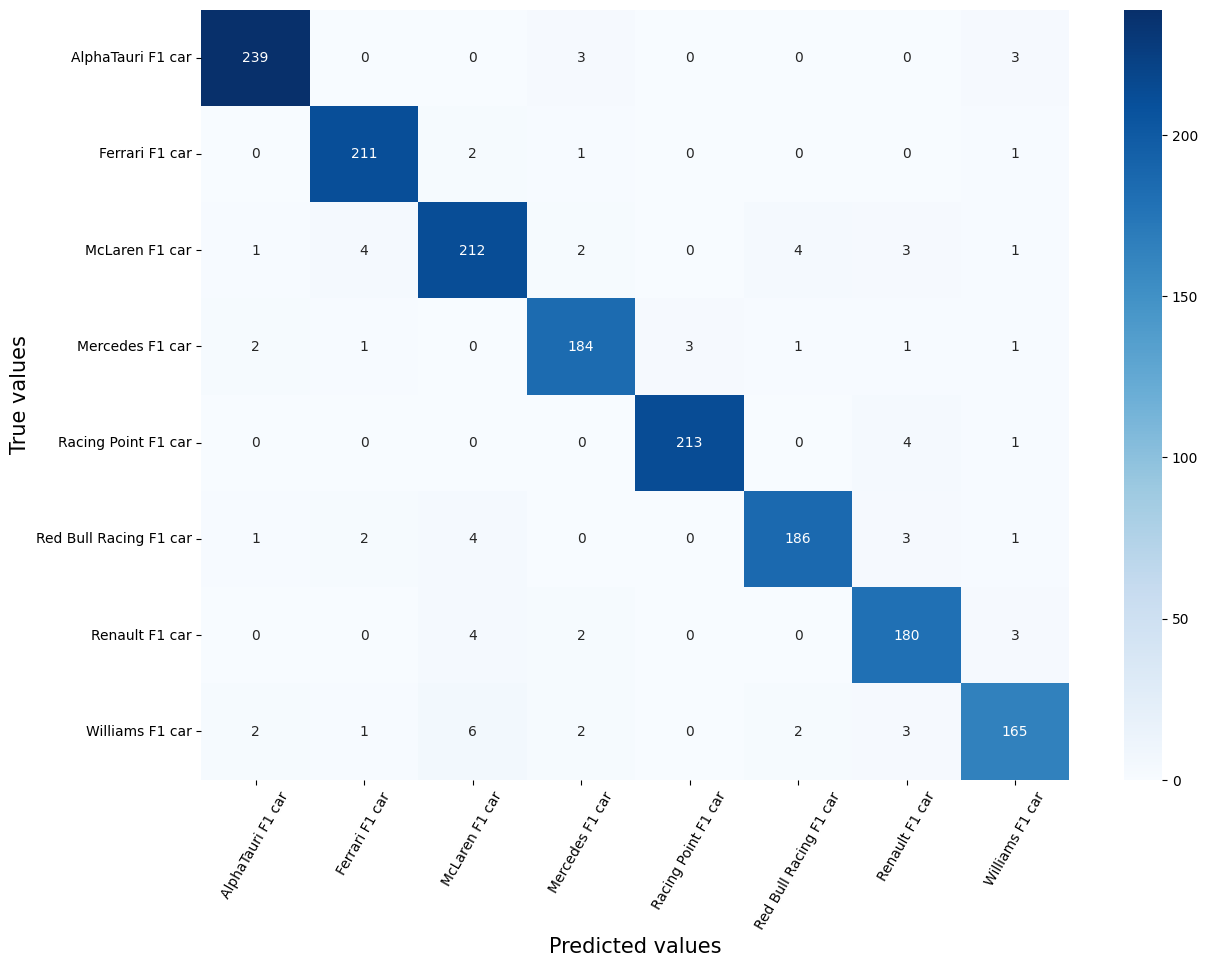

In [ ]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

In [ ]:
# Saving the files for re-use

output_model_file = './RESNET-18-FULL.bin'

model_to_save = resnet18_all
torch.save(model_to_save, output_model_file)

print('All files saved')

All files saved


#### Fine Tune VGG-16 model - Freeze All Feature Extraction Layers

In [ ]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
set_seed(seed)
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all layers except the last one
for param in vgg16.features.parameters():
    param.requires_grad = False

# Customize the last fully connected layer for your task
num_classes = len(dataset.classes)  # Set the number of output classes for your task
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

# Move the model to the device
vgg16 = vgg16.to(device)

/home/varun/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/varun/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    vgg16.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:
      
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0424, Train Accuracy - 0.5070
Epoch 2/10: Train Loss - 0.0200, Train Accuracy - 0.7758
Epoch 3/10: Train Loss - 0.0096, Train Accuracy - 0.8992
Epoch 4/10: Train Loss - 0.0053, Train Accuracy - 0.9467
Epoch 5/10: Train Loss - 0.0036, Train Accuracy - 0.9634
Epoch 6/10: Train Loss - 0.0032, Train Accuracy - 0.9680
Epoch 7/10: Train Loss - 0.0018, Train Accuracy - 0.9853
Epoch 8/10: Train Loss - 0.0017, Train Accuracy - 0.9857
Epoch 9/10: Train Loss - 0.0018, Train Accuracy - 0.9824
Epoch 10/10: Train Loss - 0.0017, Train Accuracy - 0.9820


In [ ]:
# Set the model to evaluation mode
set_seed(seed)
vgg16.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = vgg16(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels]) 

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 71.41%


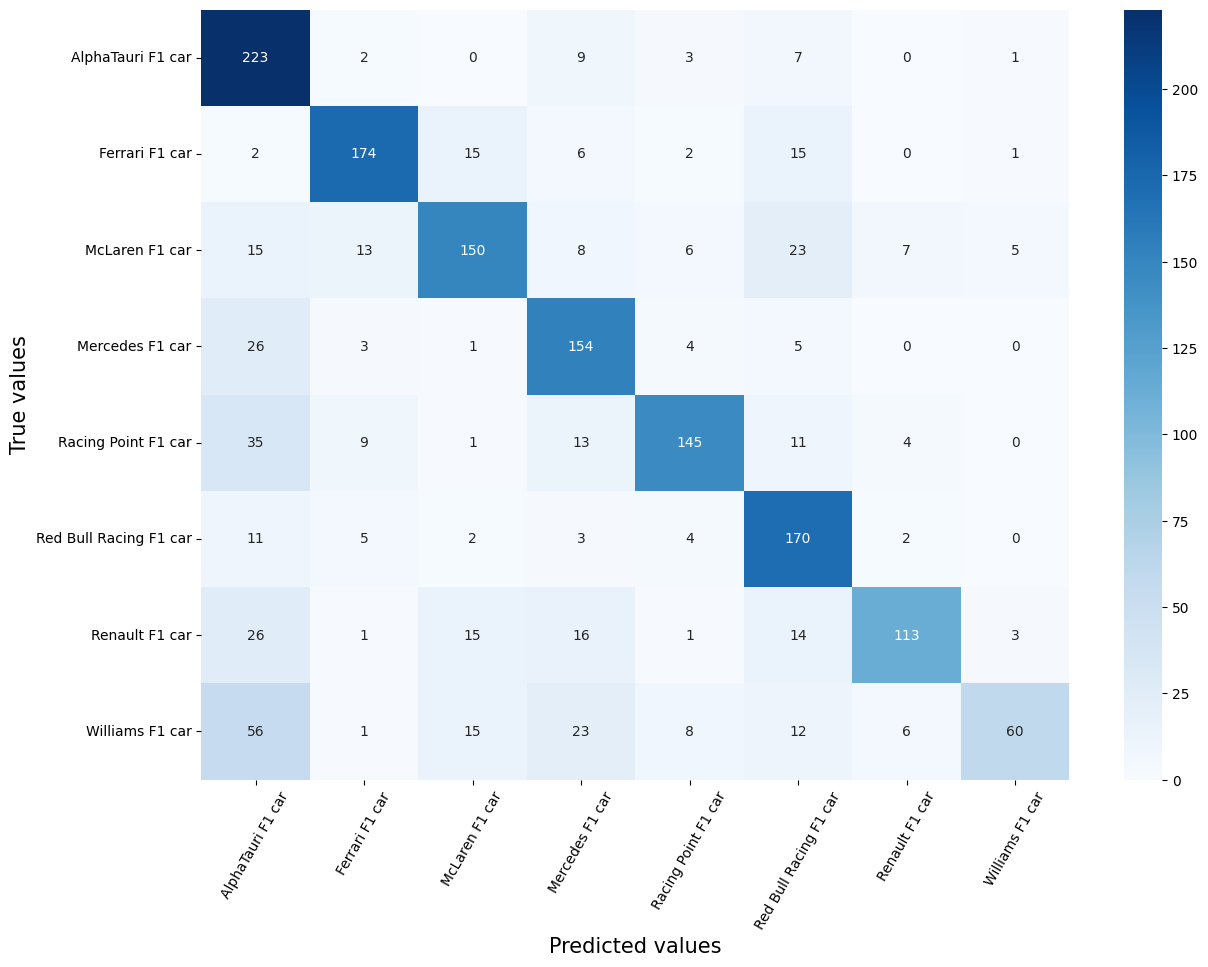

In [ ]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

In [ ]:
# Saving the files for re-use

output_model_file = './VGG-16 model.bin'

model_to_save = vgg16
torch.save(model_to_save, output_model_file)

print('All files saved')

All files saved


#### Fine Tune Full VGG-16 Model

In [ ]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

set_seed(seed)
# Load the pre-trained VGG16 model
vgg16_all = models.vgg16(pretrained=True)



# Customize the last fully connected layer for your task
num_classes = len(dataset.classes)  # Set the number of output classes for your task
vgg16_all.classifier[6] = nn.Linear(vgg16_all.classifier[6].in_features, num_classes)

# Move the model to the device
vgg16_all = vgg16_all.to(device)

/home/varun/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/varun/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_all.parameters(), lr=0.0001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    vgg16_all.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:
      
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16_all(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0274, Train Accuracy - 0.6888
Epoch 2/10: Train Loss - 0.0092, Train Accuracy - 0.9088
Epoch 3/10: Train Loss - 0.0059, Train Accuracy - 0.9437
Epoch 4/10: Train Loss - 0.0035, Train Accuracy - 0.9679
Epoch 5/10: Train Loss - 0.0032, Train Accuracy - 0.9709
Epoch 6/10: Train Loss - 0.0022, Train Accuracy - 0.9808
Epoch 7/10: Train Loss - 0.0018, Train Accuracy - 0.9817
Epoch 8/10: Train Loss - 0.0014, Train Accuracy - 0.9872
Epoch 9/10: Train Loss - 0.0028, Train Accuracy - 0.9773
Epoch 10/10: Train Loss - 0.0011, Train Accuracy - 0.9889


In [ ]:
# Set the model to evaluation mode
set_seed(seed)
vgg16_all.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = vgg16_all(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels]) 

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 93.99%


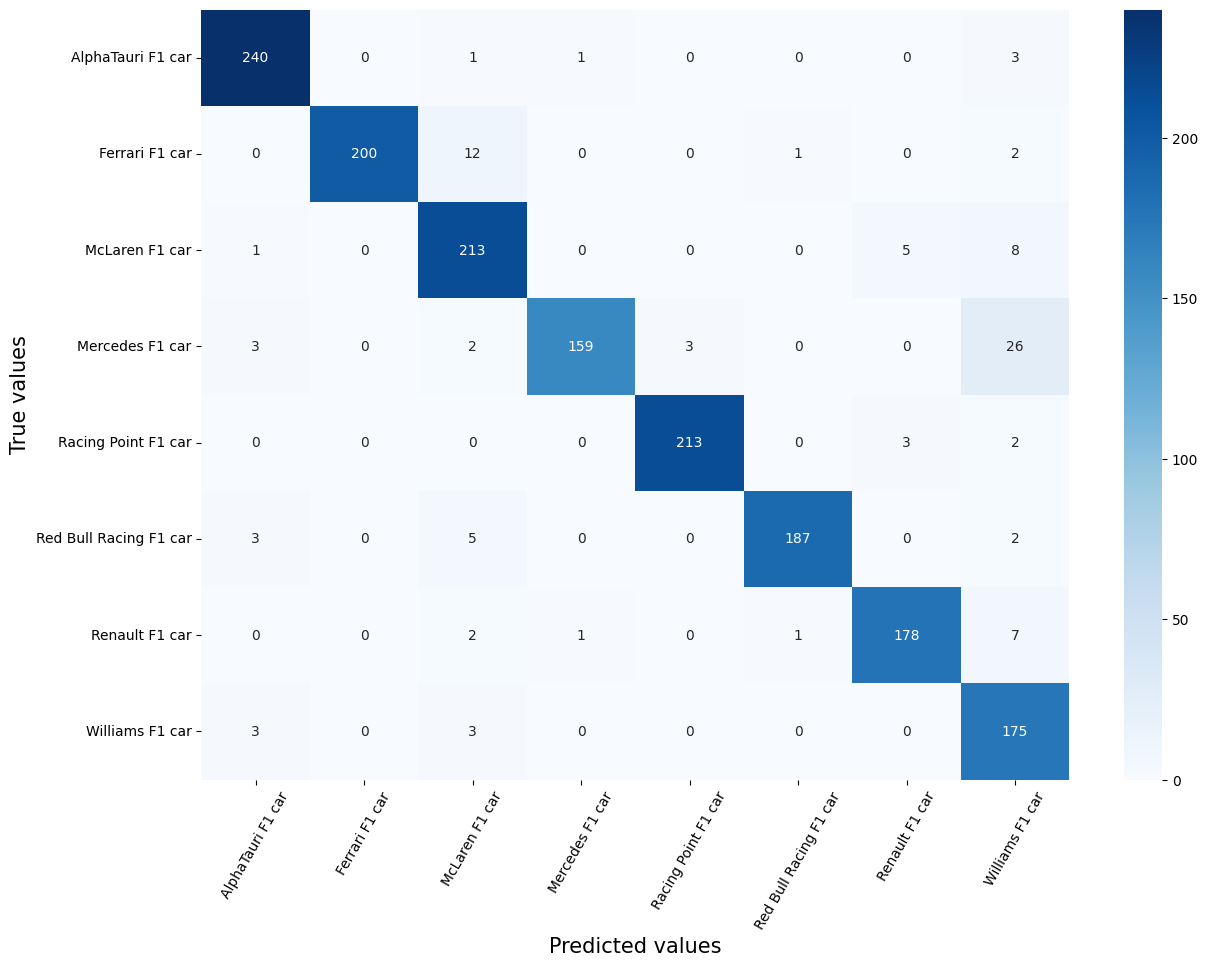

In [ ]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

In [ ]:
# Saving the files for re-use

output_model_file = './VGG-16 model-full.bin'

model_to_save = vgg16_all
torch.save(model_to_save, output_model_file)

print('All files saved')

All files saved


#### Fine Tune MobileNet_V2 Model - Freeze all feature extraction layers

In [ ]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

set_seed(seed)
# Load the pre-trained MobilenetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in mobilenet_v2.parameters():
    param.requires_grad = False

# Customize the last fully connected layer for your task
num_classes = len(dataset.classes)
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.classifier[1].in_features, num_classes)

# Move the model to the device
mobilenet_v2 = mobilenet_v2.to(device)

/home/varun/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/varun/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.parameters(), lr=0.0001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    mobilenet_v2.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_v2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0594, Train Accuracy - 0.3310
Epoch 2/10: Train Loss - 0.0483, Train Accuracy - 0.5716
Epoch 3/10: Train Loss - 0.0415, Train Accuracy - 0.6552
Epoch 4/10: Train Loss - 0.0371, Train Accuracy - 0.6854
Epoch 5/10: Train Loss - 0.0340, Train Accuracy - 0.7094
Epoch 6/10: Train Loss - 0.0317, Train Accuracy - 0.7280
Epoch 7/10: Train Loss - 0.0302, Train Accuracy - 0.7312
Epoch 8/10: Train Loss - 0.0287, Train Accuracy - 0.7455
Epoch 9/10: Train Loss - 0.0276, Train Accuracy - 0.7485
Epoch 10/10: Train Loss - 0.0267, Train Accuracy - 0.7486


In [ ]:
# Set the model to evaluation mode
set_seed(seed)
mobilenet_v2.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = mobilenet_v2(inputs)
      
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels]) 

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 79.70%


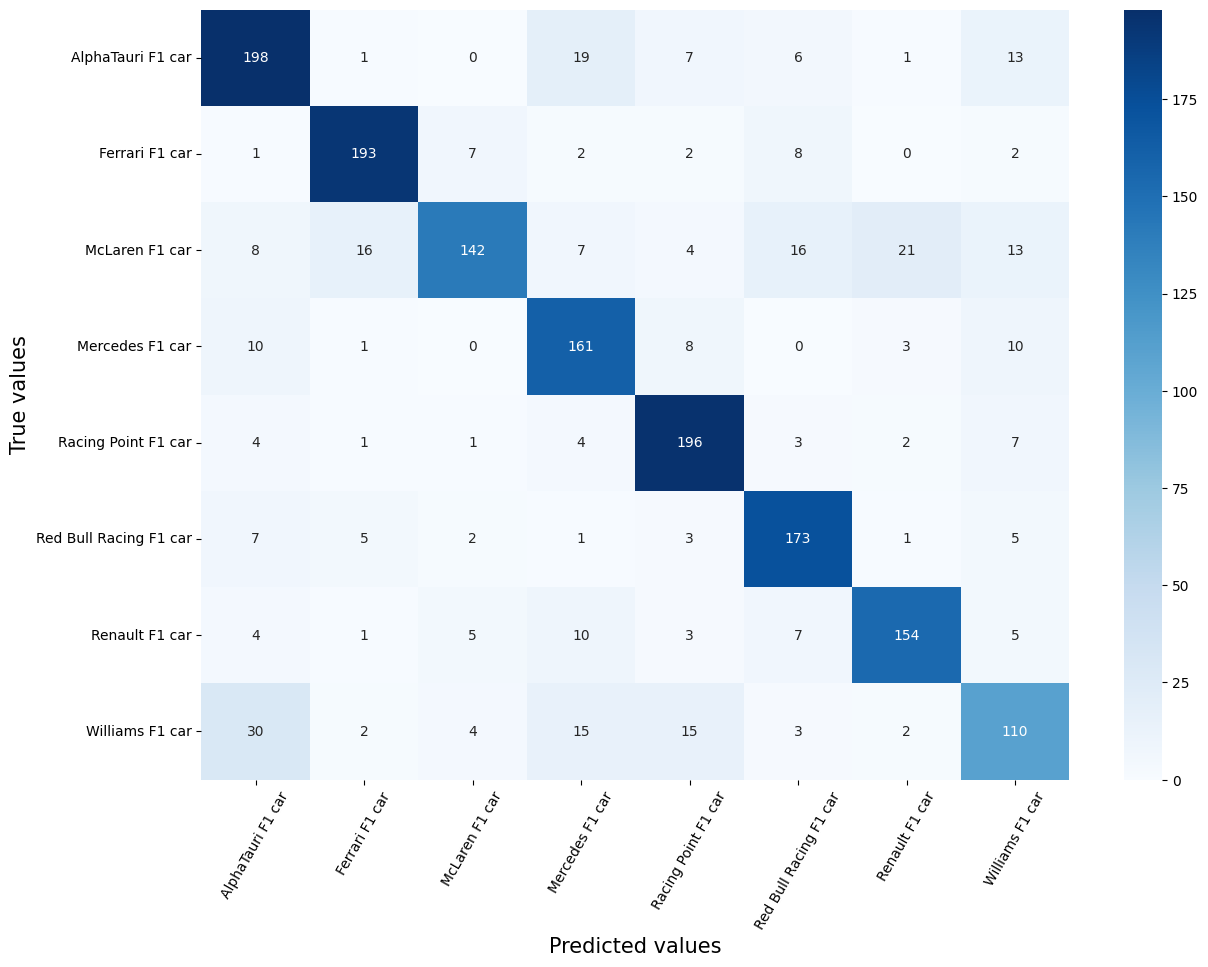

In [ ]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

In [ ]:
# Saving the files for re-use

output_model_file = './mobilenet_v2.bin'

model_to_save = mobilenet_v2
torch.save(model_to_save, output_model_file)

print('All files saved')

All files saved


#### Fine Tune Full MobileNet-V2 Model

In [ ]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

set_seed(seed)
# Load the pre-trained MobilenetV2 model
mobilenet_v2_all = models.mobilenet_v2(pretrained=True)


# Customize the last fully connected layer for your task
num_classes = len(dataset.classes)
mobilenet_v2_all.classifier[1] = nn.Linear(mobilenet_v2_all.classifier[1].in_features, num_classes)

# Move the model to the device
mobilenet_v2_all = mobilenet_v2_all.to(device)

/home/varun/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/varun/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Set loss function and optimizer
set_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2_all.parameters(), lr=0.0001)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    mobilenet_v2_all.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:
      
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_v2_all(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}: Train Loss - {train_loss:.4f}, Train Accuracy - {train_accuracy:.4f}')

Epoch 1/10: Train Loss - 0.0201, Train Accuracy - 0.7985
Epoch 2/10: Train Loss - 0.0059, Train Accuracy - 0.9494
Epoch 3/10: Train Loss - 0.0032, Train Accuracy - 0.9715
Epoch 4/10: Train Loss - 0.0020, Train Accuracy - 0.9898
Epoch 5/10: Train Loss - 0.0015, Train Accuracy - 0.9874
Epoch 6/10: Train Loss - 0.0008, Train Accuracy - 0.9947
Epoch 7/10: Train Loss - 0.0014, Train Accuracy - 0.9877
Epoch 8/10: Train Loss - 0.0009, Train Accuracy - 0.9934
Epoch 9/10: Train Loss - 0.0006, Train Accuracy - 0.9946
Epoch 10/10: Train Loss - 0.0005, Train Accuracy - 0.9962


In [ ]:
# Set the model to evaluation mode
set_seed(seed)
mobilenet_v2_all.eval()

# Initialize counters
correct = 0
total = 0
pred_labels = []
true_labels = []

# No gradient calculation needed in evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the device used (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = mobilenet_v2_all(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        pred_labels.append(predicted)
        true_labels.extend([l.item() for l in labels])        

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


val_labels = torch.cat(pred_labels)
# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation accuracy: {accuracy:.2f}%')

Validation accuracy: 96.70%


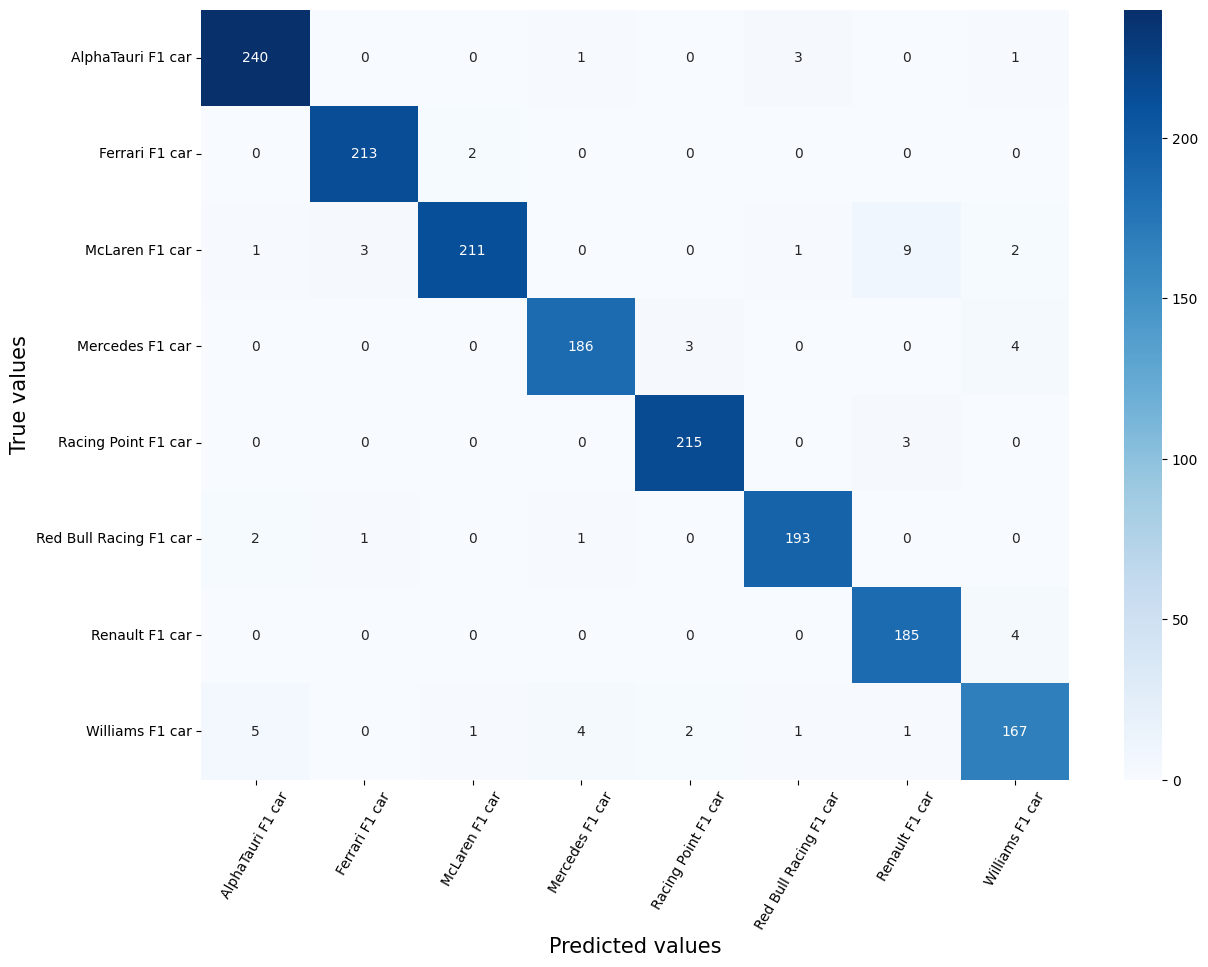

In [ ]:
val_labels_cpu = val_labels.cpu()
make_confusion_matrix(true_labels,val_labels_cpu,dataset.classes)

In [ ]:
# Saving the files for re-use

output_model_file = './mobilenet_v2-full.bin'

model_to_save = mobilenet_v2_all
torch.save(model_to_save, output_model_file)

print('All files saved')

All files saved
